# Building a RNN for Stock Trending

Using a stacked-LSTM model approach

This is a walk-through (revisit) and where I will type from TF Cert Videos. The approach will be completed in 15 steps.

The `LSTM` will be stacked and adjustments made to avoid overfitting.

## Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

## Get Ticker Infomation

The dataset for the exercise does not exist. *So* I went out to `Yahoo Finance` price and history to get my own. This is good practice.

Required installation of `pandas-datareader`. Note: a `-` versus `_` for the name to install. To activate the library, it is an `_`. Environment uses `pandas-datareader` version $0.8.1$, along with:
* `libxml2` $2.9.10$
* `libslt` $1.1.33$
* `lxml` $4.6.2$

`pandas` version: $1.1.5$

Errors arose with version $0.8.1$. Removed.

Install via `pip` for version $0.9.0$

In [2]:
# import external pandas_datareader library with alias of pdr
import pandas_datareader as pdr

# import datetime internal module, native to `Python`
import datetime

**Update:** Using `pip` to call down `pandas-datareader` version $0.9.0$

In [3]:
ticker = "TSLA"

In [4]:
#datetime.datetime is a data type within the datetime module
# Calling data for three (3) years
# start = datetime.datetime(2017, 12, 13)  # Can be specific dates YYYY, MM, DD
end = datetime.datetime(2020, 10, 31)
start = datetime.date(end.year-3,1,1)  # Set to pull three years ago

start_test = datetime.datetime(2020,11,1)
end_test = datetime.datetime(2020,11,30)

df = pdr.DataReader(ticker, 'yahoo', start, end)
df_test = pdr.DataReader(ticker, 'yahoo', start_test, end_test)

Convert from dataframe object into a csv.

There are two dataframes. One is the historical data for the model training - three years.
Second is the one month, specifically `Nov. 2020`.

In [5]:
df.to_csv(ticker + '_to_csv.csv')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,44.066002,42.192001,42.972000,43.397999,29616500.0,43.397999
2017-01-04,45.599998,42.862000,42.950001,45.397999,56067500.0,45.397999
2017-01-05,45.495998,44.389999,45.284000,45.349998,29558500.0,45.349998
2017-01-06,46.062000,45.090000,45.386002,45.801998,27639500.0,45.801998
2017-01-09,46.383999,45.599998,45.793999,46.256001,19897500.0,46.256001


In [6]:
df_test.to_csv(ticker + '_2020-Nov.csv')

## RNN development

### Data Preprocessing

In [7]:
# Import the training set
dataset_train = pd.read_csv(ticker + '_to_csv.csv')
training_set = dataset_train.iloc[:, 2:3].values  # Calling on 'Open' column

### Feature scaling

For an RNN, it is recommended to use `Normalization`

$x_{norm} = \frac{x-min(x)}{max(x) - min(x)}$

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Data Strucuture with 60 Timesteps and 1 output

60 timesteps in the past and then Time+1

In [9]:
X_train = []
y_train = []
for i in range(60, 965):
    X_train.append(training_set_scaled[i-60:i, 0])  # Call upon the previous 60
    y_train.append(training_set_scaled[i, 0])  # i because it is the 61th index
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping Data

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Creating a 3_D shape, numpy arrays stacked into indicators

## Building the RNN

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [12]:
# Initializing the RNN
regressor = Sequential()

### Adding first LSTM layer and some Dropout regularization

In [13]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))  # Starting with 50 neurons, True for stacking
regressor.add(Dropout(0.2))  # Drop 20%

### Rest of the LSTMs

In [14]:
# 2nd LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True))  # Starting with 50 neurons, remove input layer
regressor.add(Dropout(0.2))  # Drop 20%

# 3rd LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True))  # Starting with 50 neurons, True for stacking
regressor.add(Dropout(0.2))  # Drop 20%

# 4th LSTM layer
regressor.add(LSTM(units = 50))  # Starting with 50 neurons, False - Last in the stack
regressor.add(Dropout(0.2))  # Drop 20%

### Output Layer of RNN

In [15]:
# Output Layer
regressor.add(Dense(units = 1))

## Compile the RNN

In [16]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')  # Adam is awlays a good place to start

### Fittting the RNN to Training set

In [17]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
29/29 [==============================] - 2s 61ms/step - loss: 0.0171
Epoch 2/100
29/29 [==============================] - 2s 56ms/step - loss: 0.0035
Epoch 3/100
29/29 [==============================] - 2s 56ms/step - loss: 0.0033
Epoch 4/100
29/29 [==============================] - 2s 55ms/step - loss: 0.0030
Epoch 5/100
29/29 [==============================] - 2s 57ms/step - loss: 0.0023
Epoch 6/100
29/29 [==============================] - 2s 55ms/step - loss: 0.0027
Epoch 7/100
29/29 [==============================] - 2s 56ms/step - loss: 0.0039
Epoch 8/100
29/29 [==============================] - 2s 69ms/step - loss: 0.0023
Epoch 9/100
29/29 [==============================] - 2s 55ms/step - loss: 0.0025
Epoch 10/100
29/29 [==============================] - 2s 55ms/step - loss: 0.0022
Epoch 11/100
29/29 [==============================] - 2s 55ms/step - loss: 0.0029
Epoch 12/100
29/29 [==============================] - 2s 56ms/step - loss: 0.0023
Epoch 13/100
29/29 [=====

29/29 [==============================] - 2s 55ms/step - loss: 7.7327e-04
Epoch 100/100
29/29 [==============================] - 2s 54ms/step - loss: 9.2571e-04


# Making the Predictions and Visualization

In [18]:
# Import the test set
dataset_test = pd.read_csv(ticker +'_2020-Nov.csv')
real_stock_price = dataset_test.iloc[:, 2:3].values  # Calling on 'Open' column

In [19]:
real_stock_price  # One month of stock values, e.g. Nov. 2020

array([[392.29998779],
       [406.69000244],
       [417.1000061 ],
       [424.        ],
       [424.27999878],
       [421.        ],
       [396.02999878],
       [410.57998657],
       [409.51998901],
       [401.66000366],
       [404.08999634],
       [433.01000977],
       [443.5       ],
       [487.57000732],
       [489.05999756],
       [501.79000854],
       [526.20001221],
       [545.36999512],
       [578.45001221],
       [554.51000977]])

In [20]:
# Get the predicted stock price
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)  # axis -> Vertical
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values  # find 60 previous and then the test area
# reshape
inputs = inputs.reshape(-1, 1)  # reshape into numpy array

# scale the inputs from original dataframe
inputs = sc.transform(inputs)

### Create similiar For ... Loop structure, But `X_test`

In [21]:
X_test = []  # Change to tester

for i in range(60, 80):  # Only need the one month 20+60.
    X_test.append(inputs[i-60:i, 0])  # Call upon the previous 60, "inputs"
X_test = np.array(X_test)  # 60 previous in one column

# 3D structure format
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)  # execute the regressor, stored in variable

# Inverse the scaling to get the original dollar value format
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [22]:
predicted_stock_price

array([[424.26804],
       [423.45053],
       [423.3584 ],
       [424.2084 ],
       [425.34494],
       [426.62292],
       [427.93198],
       [428.68185],
       [428.98596],
       [429.17374],
       [429.28815],
       [429.32562],
       [430.58798],
       [432.0188 ],
       [434.33728],
       [436.70538],
       [438.509  ],
       [440.60748],
       [442.30884],
       [444.06183]], dtype=float32)

## Final Prediction Results

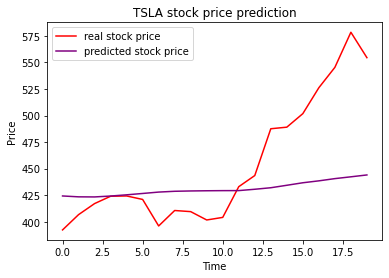

In [23]:
# Visualizations

plt.plot(real_stock_price, color = 'red', label="real stock price")
plt.plot(predicted_stock_price, color = 'purple', label="predicted stock price")
plt.title(ticker + " stock price prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()